# Store Sales Prediction
#### A Beginner's Guide to Univariate Time Series Analysis with Python

### Introduction

In this project, we would be carrying out a time series analysis on the grocery sales of Favorita stores in Ecuador. The data was downloaded from [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data) and contains information about the sales made between January 1, 2013 and August 15, 2017. The data contains information about the daily sales of products such as the store, category of product, if the product was on promotion and also external factors such as holiday events and oil prices. However, the focus of this project is on univariate time series. Hence, the sales will be aggregated across all stores, categories and days to give a monthly aggregation of the sales.
<br>
<br>
The aim of this project is to explain the basics of Univariate Time Series Analysis (TSA) such that anyone who is new to TSA will be able to carry out their own analysis with a proper understanding of the process. Prerequisites to following this guide include:
* knowledge of pandas for data manipulation
* knowledge of matplotlib for data visualization
* basic understanding of ARIMA and SARIMA models

The time series analysis will be carried out using the statsmodels python library.

#### Python Libraries and Functions

In [1]:
# for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt


# for time series analysis
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss


# to ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# set default size for graphs
plt.rcParams["figure.figsize"] = (20, 10)

#### User-defined Functions

In [2]:
def view_stationarity(series, series_name):
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()
    plt.plot(series, label=series_name)
    plt.plot(rolmean, color='red', label='Moving Average')
    plt.plot(rolstd, color='black', label='Moving STD')
    plt.legend();

In [3]:
def test_stationarity(series):
    print('===========================================')
    print('ADF Test')
    print('-------------------------------------------')
    adf_test = adfuller(series, autolag='AIC')
    adf_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_result[f'Critical Value ({key})'] = value
    print(adf_result.to_string())
    print()
    if adf_test[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")
    print('===========================================')
    print()

    print()
    print('===========================================')
    print('KPSS Test')
    print('-------------------------------------------')
    kpss_test = kpss(series, regression='c', nlags='auto')
    kpss_result = pd.Series(kpss_test[0:3], index=['Test Statistic','p-value','Number of Lags Used'])
    for key,value in kpss_test[3].items():
        kpss_result[f'Critical Value {key}'] = value
    print(kpss_result.to_string())
    print()
    if kpss_test[1] <= 0.05:
        print("Data is non-stationary")
    else:
        print("Data is stationary")
    print('===========================================')

In [4]:
def eval_ts_model(series, test, pred):
    # calculate root mean square error
    print(f'RMSE: {rmse(test, pred)}')

    # plot predictions and actual values
    plt.subplot(1,2,1)
    plt.plot(series, label='actual sales')
    plt.plot(pred, label='predicted sales')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(test, label='actual sales')
    plt.plot(pred, label='predicted sales')
    plt.xticks(pd.date_range(test.index[0], test.index[-1], freq='MS'), rotation = 45)
    plt.grid()
    plt.legend();

### Data Preparation

In [5]:
# read in dataset
df = pd.read_csv('../data/train.csv', parse_dates =["date"], index_col ="date")
df

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


The next cell extracts the time series from the data by aggregating the sales to a monthly view.

In [6]:
# aggregate the sales on a monthly basis
ts = df.sales.resample('MS').sum().round().astype(int)
# drop the last record since it's not a complete month
ts.drop('2017-08-01', inplace=True)
ts

date
2013-01-01    10327625
2013-02-01     9658960
2013-03-01    11428497
2013-04-01    10993465
2013-05-01    11597704
2013-06-01    11689344
2013-07-01    11257401
2013-08-01    11737789
2013-09-01    11792933
2013-10-01    11775620
2013-11-01    12356559
2013-12-01    15803117
2014-01-01    18911641
2014-02-01    12038353
2014-03-01    20365584
2014-04-01    12861251
2014-05-01    13379785
2014-06-01    13319958
2014-07-01    19421891
2014-08-01    13885176
2014-09-01    20022416
2014-10-01    20396101
2014-11-01    20531635
2014-12-01    24340454
2015-01-01    14896922
2015-02-01    13742396
2015-03-01    15598608
2015-04-01    14955068
2015-05-01    17730368
2015-06-01    21615360
2015-07-01    22209619
2015-08-01    22963674
2015-09-01    23240882
2015-10-01    23878268
2015-11-01    22804953
2015-12-01    27243982
2016-01-01    23977805
2016-02-01    21947409
2016-03-01    23131781
2016-04-01    25963025
2016-05-01    24779432
2016-06-01    22209219
2016-07-01    23462672
2016-0

#### Decomposing the Time Series

This next step is to break down the time series into its different components to see if it contains any trends or seasonality. This step is necessary because most time series models assume that the data is stationary i.e. contains no trends or seasonality.

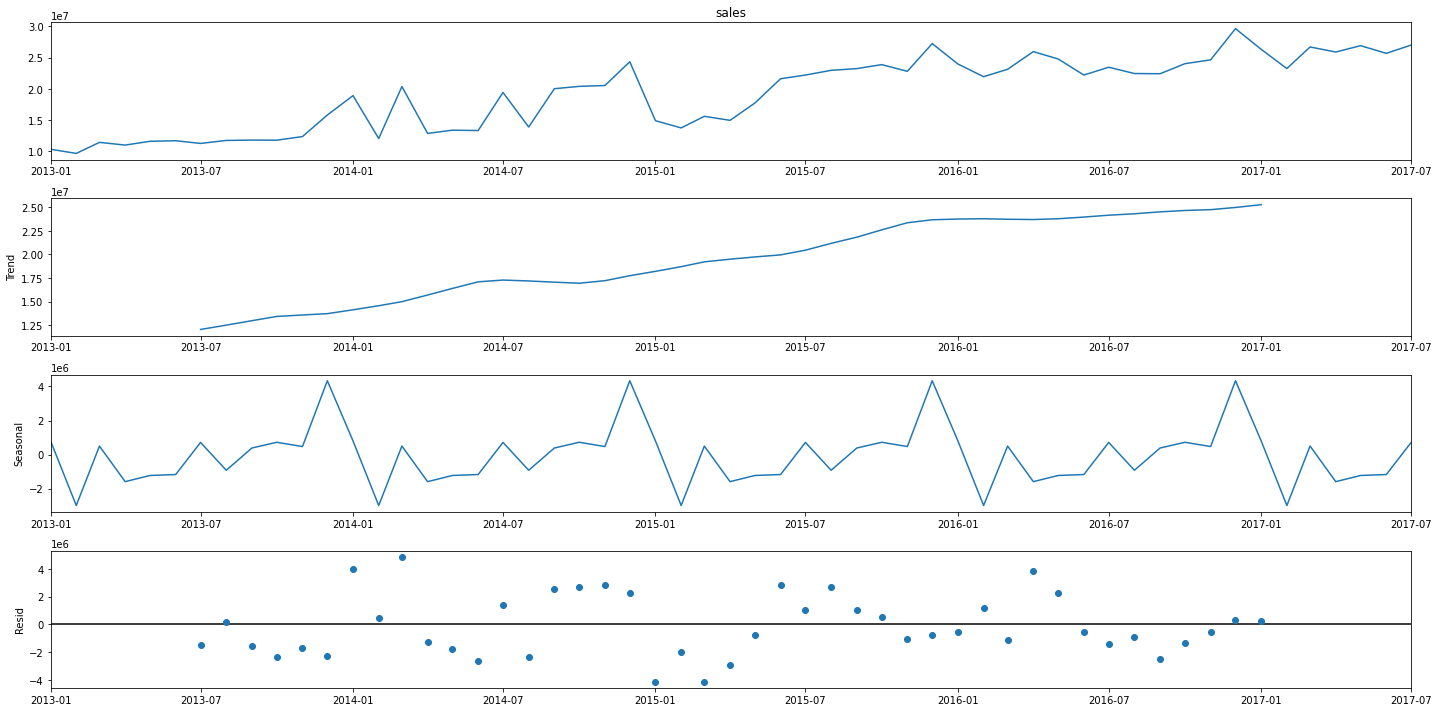

In [7]:
decomposition = seasonal_decompose(ts, model='additive')
decomposition.plot();

The first plot is a plot of the original time series. The second plot shows the trend. An obvious upward or downward tilt of the line indicates the presence of a trend. The third plot shows the presence of seasonality in the series. This is usually indicated if a pattern can be observed in the graph. The final plot shows the irregularities/noise in the series commonly referred to as residual noise.

For the time series in our case study, it can be observed that there is an upward trend and also, the series is seasonal. Therefore, the time series is not stationary. Other tests can be carried out to confirm if the data is stationary or not.

#### Testing for Stationarity

##### Visual assessment of stationarity

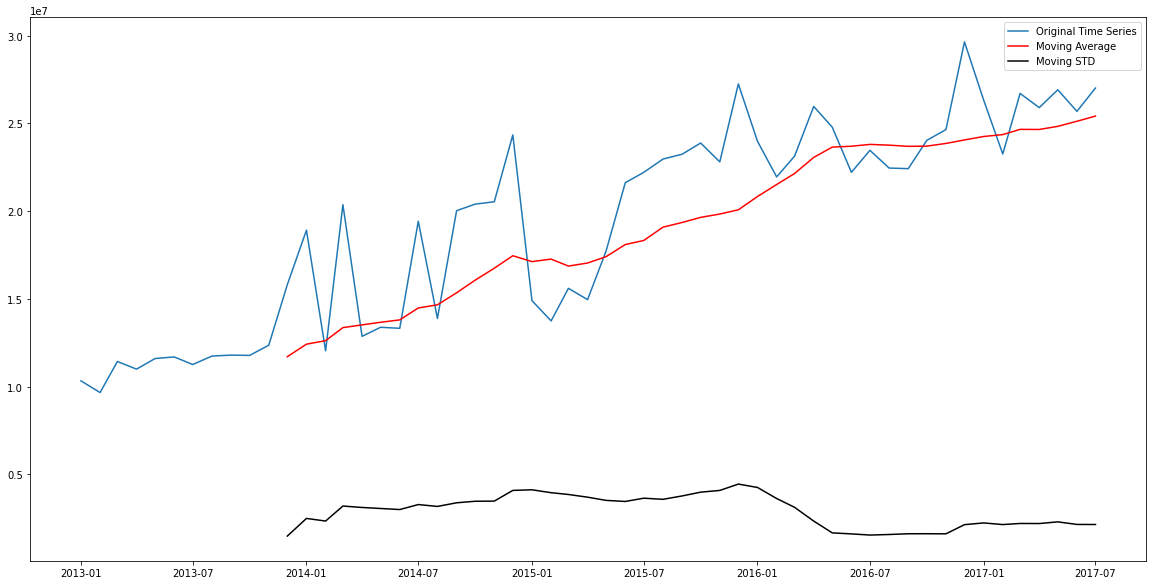

In [8]:
view_stationarity(ts, 'Original Time Series')

From the graph above, it can be observed that the series is not stationary. A stationary series will have a flat moving average and standard deviation. However, some statistical tests such as the Augumented Dickey-Fuller (ADF) and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests can be used to test for stationarity.

In [9]:
test_stationarity(ts)

ADF Test
-------------------------------------------
Test Statistic                 -1.556189
p-value                         0.505556
Number of Lags Used             1.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796

Data is non-stationary


KPSS Test
-------------------------------------------
Test Statistic         1.125216
p-value                0.010000
Number of Lags Used    4.000000
Critical Value 10%     0.347000
Critical Value 5%      0.463000
Critical Value 2.5%    0.574000
Critical Value 1%      0.739000

Data is non-stationary


For **ADF**, the condition for **non-stationarity** is that the p-value is greater than 0.05 and that the test statistic is greater than the three critical values. On the other hand, for **KPSS**, the condition for **stationarity** is that the p-value is less than 0.05 and the test statistic is greater than the three critical values.

Both tests suggest that our time-series is non-stationary. To make the series stationary, we will be applying differencing to the series and running the test again. 

#### Differencing

Differencing refers to taking the difference between an observation and its previous observations. This is one of the most popular methods used to make time series stationary.

In [10]:
# take difference between each observation and the previous observation
ts_shift = ts - ts.shift(1)
ts_shift.dropna(inplace=True)

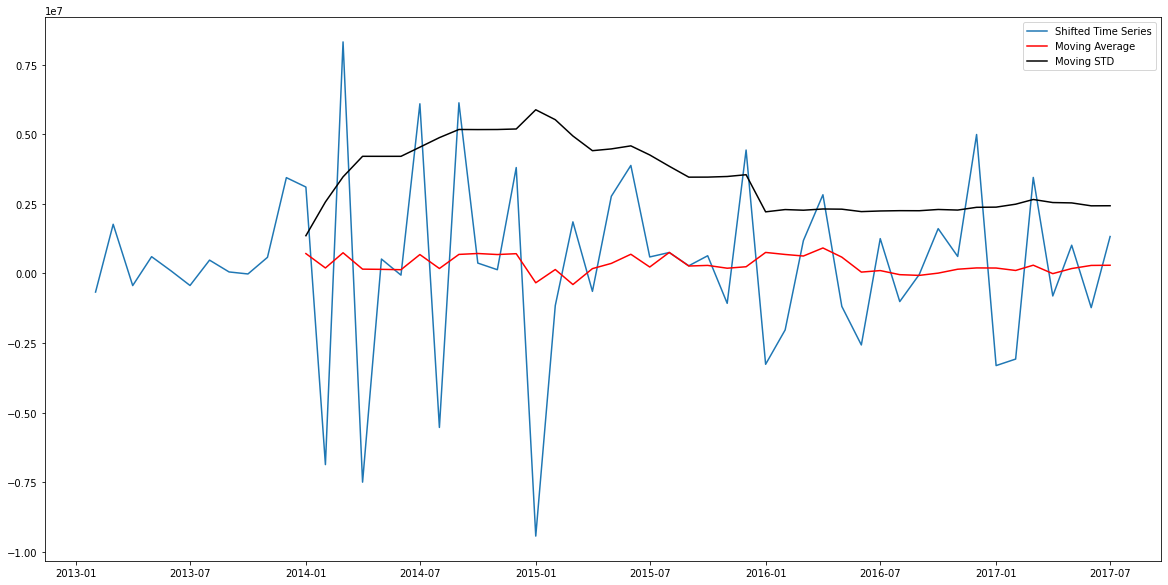

In [11]:
view_stationarity(ts_shift, 'Shifted Time Series')

In [12]:
test_stationarity(ts_shift)

ADF Test
-------------------------------------------
Test Statistic                -1.183446e+01
p-value                        7.850620e-22
Number of Lags Used            0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00

Data is stationary


KPSS Test
-------------------------------------------
Test Statistic         0.080278
p-value                0.100000
Number of Lags Used    7.000000
Critical Value 10%     0.347000
Critical Value 5%      0.463000
Critical Value 2.5%    0.574000
Critical Value 1%      0.739000

Data is stationary


From the visualization, it can observed that the moving average and standard deviation is closer to a flat line than that of the original series.The tests performed also confirm that the differenced series is now stationary. Therefore, differencing has been effective in making the time series stationary.

### Determing the Parameters for the Autoregressive Integrated Moving Average (ARIMA) model

#### Determing d

Differencing is also important in determining the value of d, one of the parameters for the ARIMA model. Since we shifted by 1 to make the series stationary, we can confirm the value of d for the ARIMA model that will be built is 1.

#### Determing p & q
##### Using ACF & PACF plots

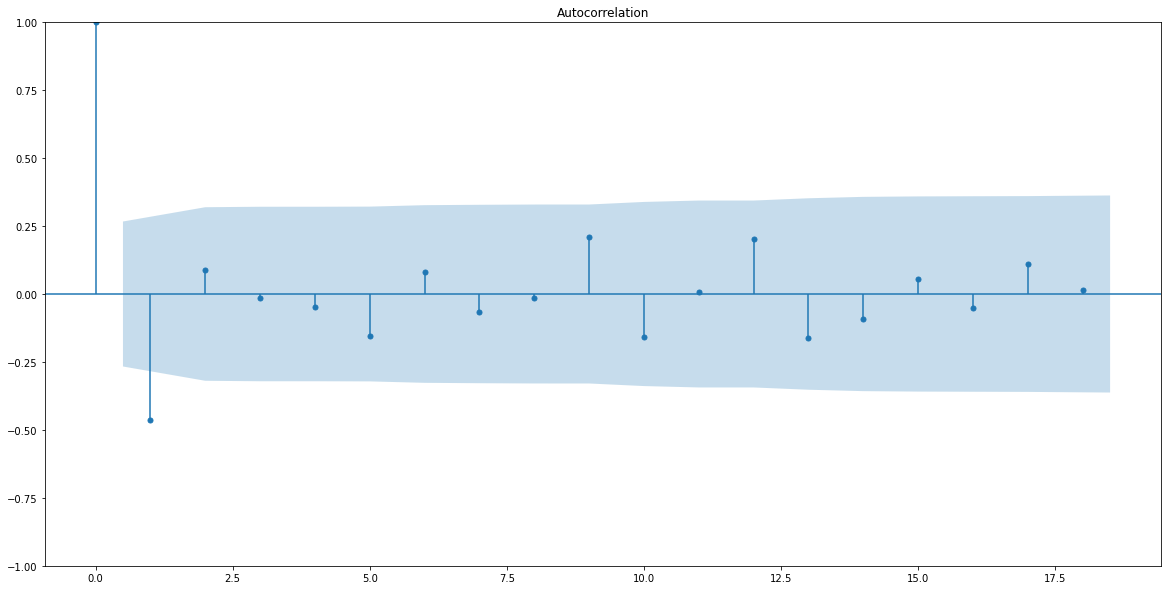

In [13]:
plot_acf(ts_shift);

According to the ACF plot, the only significant lag is 1. Hence, the value of q is estimated to be 1.

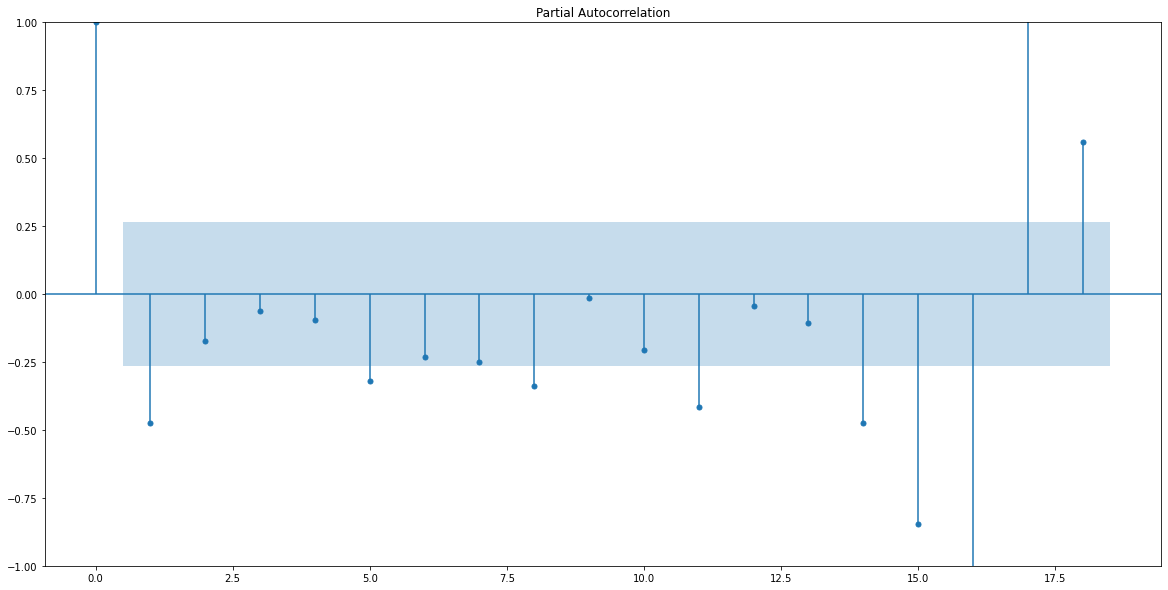

In [14]:
plot_pacf(ts_shift);

The PACF plot also has a significant lag at 1. Our value for p will be estimated at 1. Also, the auto-arima method will be used to determine the best values for p, q and d.

##### Auto-Arima

From the decomposition plot done earlier, it can be oberved that the time series is seasonal. Hence a seasonal autoregressive integrated moving average (SARIMA) model will be more appropriate. Hence when performing auto-arima to determine the hyperparameter values, the `seasonal` argument will be set to `True`.

In [15]:
# fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(ts, start_p = 1, start_q = 1,
                          m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1419.863, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1426.822, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1422.856, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1426.479, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1457.442, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1424.451, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1421.281, Time=0.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1420.142, Time=0.71 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1423.566, Time=0.29 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1421.657, Time=1.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1418.696, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1422.787, Time=0.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1419.862, Time=0.36 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1419.295, Time=0.52 sec
 ARIMA(1,0,0)(1,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   55
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -705.348
Date:                              Sun, 19 Mar 2023   AIC                           1418.696
Time:                                      10:41:58   BIC                           1425.740
Sample:                                           0   HQIC                          1421.293
                                               - 55                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.538e+06   1.09e+06      2.326      0.020       4e+05    4.68e+06
ar.L1          0.4713      0.182      2.594      0.009       0.115       0.827
ma.S.L12      -0.6778      0.362     -1.870      0.061      -1.388       0.033
sigma2      1.219e+13      0.157   7.77e+13      0.000    1.22e+13    1.22e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.45   Prob(JB):                         0.53
Heteroskedasticity (H):               0.13   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.04e+29. Standard errors may be unstable.
"""

According to the auto_arima method, the best parameter values for SARIMA is 1, 0, 0, 0, 1, 2 and 12 for p, d, q, P, D, Q and m respectively. This is based on the lowest AIC score. These parameters will be used to train the forecasting model.

It is also important to note that the values estimated for p,q, and d, (1, 0, 0) is different from the value estimated while using the classical methods (1, 1, 1). For this reason, two SARIMA models will be trained, one with p,q,d = (1, 0, 0) and another with p,g,d = (1,1,1). These two models will then be tested and their performance will be compared.

### Model Development

Before building the time series models, the time series will be split into train and test sets. The last twelve months of sales will be set aside to test the performance of both models.

In [16]:
# split the train and test sets
train = ts[:len(ts)-12]
test = ts[len(ts)-12:]

In [17]:
# train first model with parameters from classical method
model_1 = SARIMAX(train, 
                order = (1, 1, 1), 
                seasonal_order =(0, 1, 2, 12)).fit()

                                        SARIMAX Results                                        
Dep. Variable:                                   sales   No. Observations:                   43
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -498.462
Date:                                 Sun, 19 Mar 2023   AIC                           1006.924
Time:                                         10:42:00   BIC                           1013.930
Sample:                                     01-01-2013   HQIC                          1009.165
                                          - 07-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4580      0.822     -0.557      0.578      -2.070       1

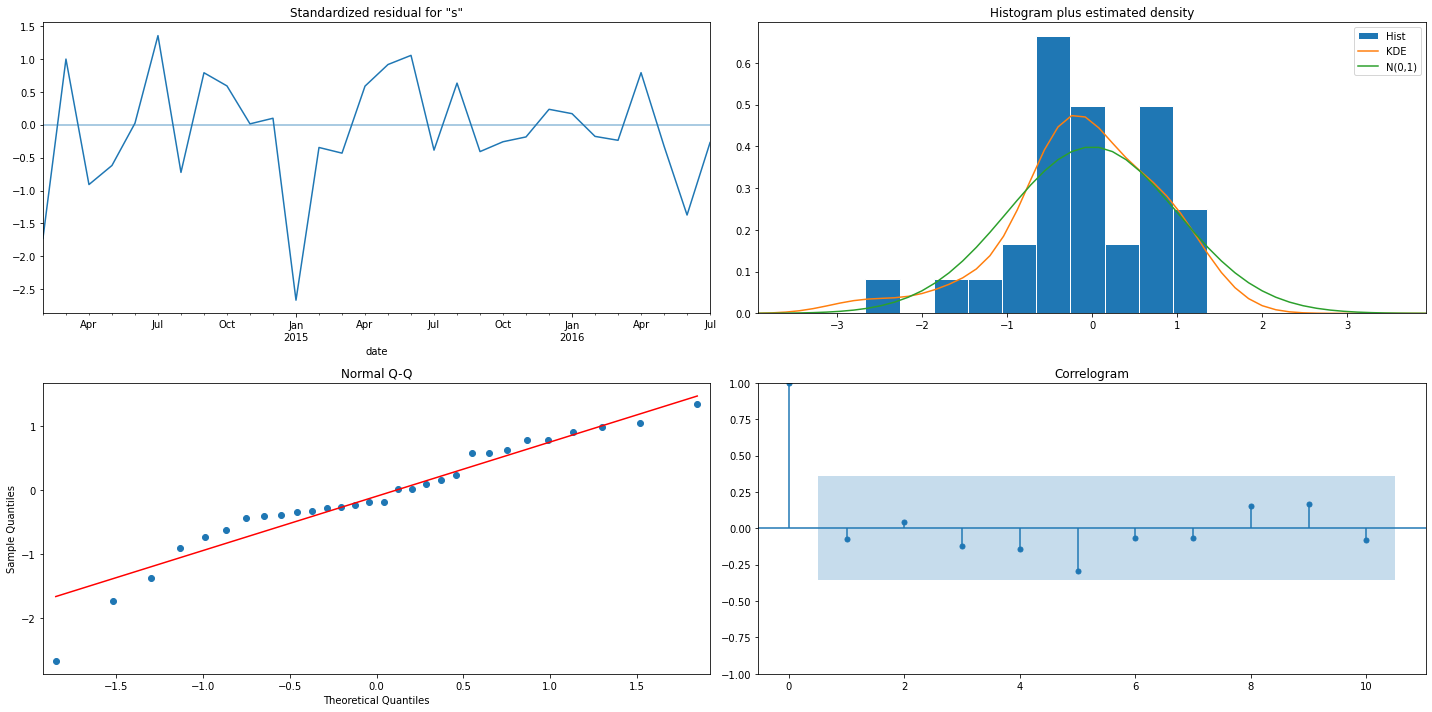

In [18]:
# inspect the details of the first model
print(model_1.summary())
model_1.plot_diagnostics()
plt.tight_layout();

In [19]:
# train second model with parameters from auto arima
model_2 = SARIMAX(train, 
                order = (1, 0, 0), 
                seasonal_order =(0, 1, 2, 12)).fit()

                                        SARIMAX Results                                        
Dep. Variable:                                   sales   No. Observations:                   43
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -517.968
Date:                                 Sun, 19 Mar 2023   AIC                           1043.937
Time:                                         10:42:04   BIC                           1049.673
Sample:                                     01-01-2013   HQIC                          1045.806
                                          - 07-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8638      0.146      5.910      0.000       0.577       1

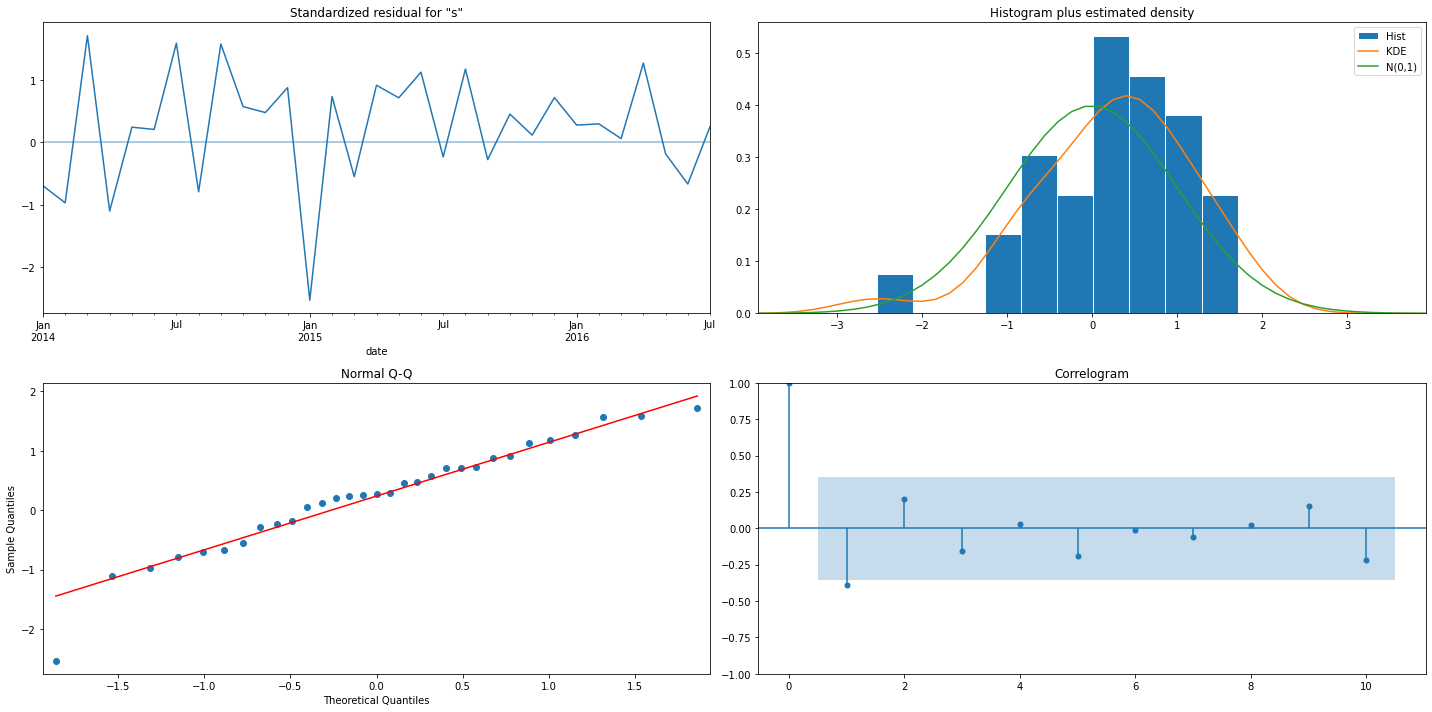

In [20]:
# inspect the details of the second model
print(model_2.summary())
model_2.plot_diagnostics()
plt.tight_layout();

The plot diagnostics generally help us understand if our model is a good fit for the data and also if we will need to take more steps before building the model such as transforming the data or re-evaluating the hyperparameter values chosen. An explanation of the different plots and what is expected to be observed can be found [here](https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/).

From the correlogram of the first model, it can be seen that appropriate values have been chosen for the model hyperparameters has there is no significant autocorrelation between the observations and their lags. However, this isn't the case for the second model.

### Model Evaluation

Both models will be evaluated in two ways. First, the root mean square error will be calculated. Second, the predicted sales will be plotted along side the actual sales for visual evaluation.

In [21]:
# set the start and end values for the period of prediction
start = len(train)
end = len(train) + len(test) - 1

In [22]:
predictions_1 = model_1.predict(start, end,
                             typ = 'levels')


RMSE: 996779.5904901423


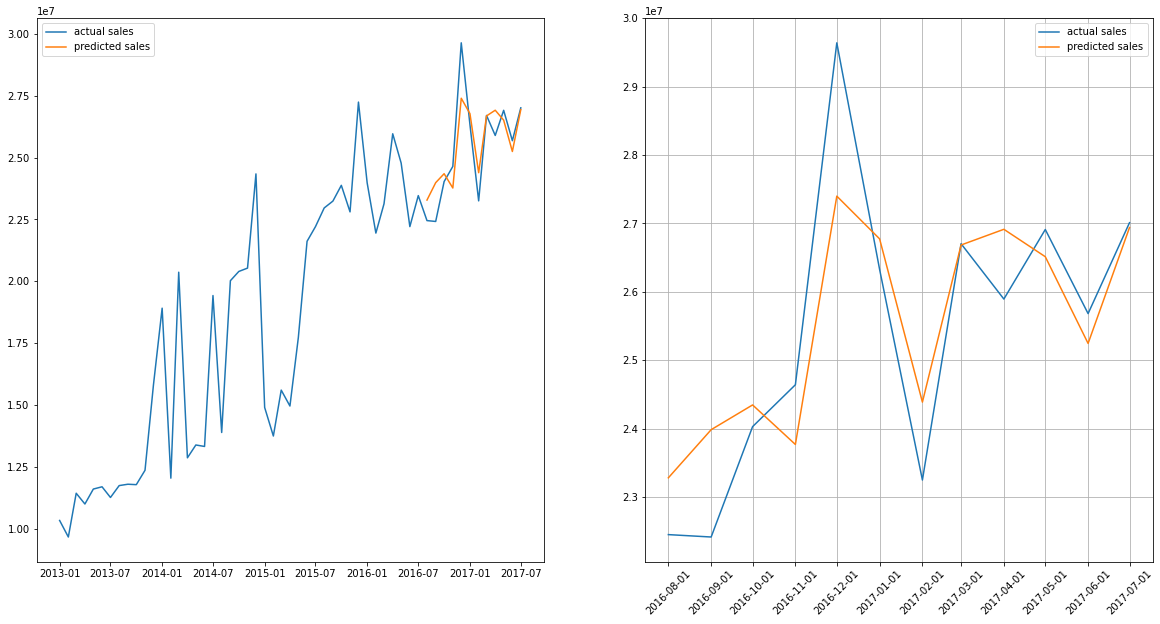

In [23]:
eval_ts_model(ts, test, predictions_1)

In [24]:
predictions_2 = model_2.predict(start, end,
                             typ = 'levels')

RMSE: 5214720.472929159


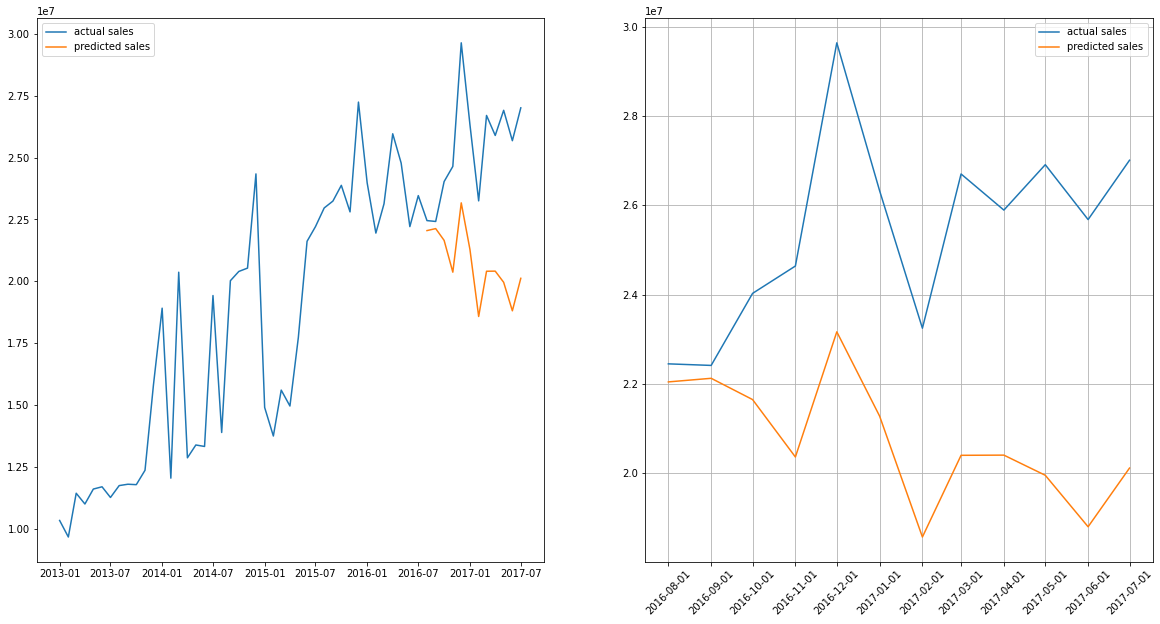

In [25]:
eval_ts_model(ts, test, predictions_2)

From on the visualizations above, it can be seen that the predicted sales for the first model is closer to the actual sales, compared to the values for the second model. Also the first model has a lower RMSE than the first model. This means that the first model is better suited to the data and generally has a better performance than the second model.

### Conclusion

In this project, univariate time series analysis of Favorita stores sales has been done. Basic concepts such as decomposing time series, testing for stationarity, choosing hyperparameters for ARIMA models, have been discussed. Also, two SARIMA models were also trained to forecast future sales for the store and their performance was compared.

#### Future Work

To improve the accuracy of the forecasts, the following can be done among others:
* exploring other methods for selecting appropriate hyperparameter values for the model
* including other information contained in the original dataset such as details about the different stores and products as well as external factors
* using other algorithms to build the forecasting model such as **Exponential Smoothening, Prophet, Long Short Term Memory (LSTM)**, etc.

### References

* [Python | ARIMA Model for Time Series Forecasting by Geeks for Geeks](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)
* [Time Series Analysis in Python | Time Series Forecasting | Data Science with Python | Edureka](https://www.youtube.com/watch?v=e8Yw4alG16Q&t=1964s&ab_channel=edureka%21)
* [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)